In [1]:
import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import regularizers
from explain import Sample_Concrete
import numpy as np

Using TensorFlow backend.
/Users/matt_rounds/miniconda2/envs/XA3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matt_rounds/miniconda2/envs/XA3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
pred_train = np.load('data/pred_train.npy')
pred_val = np.load('data/pred_val.npy')

In [4]:
scores = np.load('data/scores.npy')

In [5]:
from explain import load_data
x_train, y_train, x_val, y_val = load_data()

In [6]:
def explain_instance(idx, top_n, scores):
    selected = np.argsort(scores[idx,:])[-top_n:]
    selected_k_hot = np.zeros(784)
    selected_k_hot[selected] = 1.0
    #weighted_selected = np.multiply(scores[idx,:],selected_k_hot)
    #plt.imshow(weighted_selected.reshape(28,28), cmap='Reds')
    
    selected_n = np.argsort(scores[idx,:])[:top_n]
    selected_k_hot[selected_n] = 3.0
    
    selected_m = np.argsort(scores[idx,:])[378:378+top_n]
    selected_k_hot[selected_m] = 2.0
    plt.imshow(selected_k_hot.reshape(28,28), cmap='tab20')
    
    plt.imshow(x_val[idx,:].reshape(28,28), cmap='gray', alpha=0.3)

    plt.show()
    
    print('True label: {}'.format(np.argmax(y_val[idx])))
    print('Predicted label: {}'.format(np.argmax(pred_val[idx])))

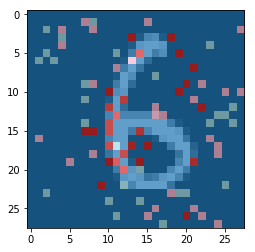

True label: 6
Predicted label: 6


In [7]:
explain_instance(3000,28, scores)

In [8]:
np.amin(scores)

-14.864575

In [20]:
accs = np.load('data/rec_accs.npy')
n_accs = np.load('data/rec_inaccs.npy')

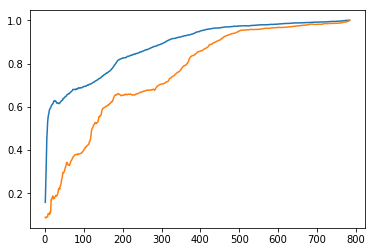

In [21]:
x = range(1,785)

plt.plot(x, accs)
plt.plot(x, n_accs)

plt.show()

(array([ 10.,  54., 170., 294., 140.,  60.,  32.,  13.,   8.,   3.]),
 array([-6.4484572 , -5.1057673 , -3.7630775 , -2.4203875 , -1.0776976 ,
         0.26499224,  1.6076821 ,  2.950372  ,  4.2930617 ,  5.6357517 ,
         6.9784417 ], dtype=float32),
 <a list of 10 Patch objects>)

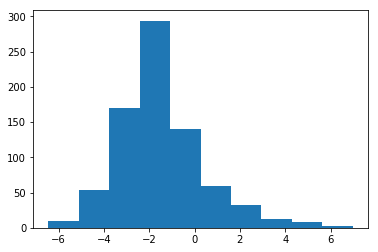

In [98]:
hist(scores[18,:])

In [41]:
trained_model = keras.models.load_model('models/original.hdf5')

In [47]:
np.argmax(trained_model.predict(x_train[0:4,:]), axis=1)

array([5, 0, 4, 1])

In [364]:
accs = np.load('data/recovery_accs.npy')
accs_r = np.load('data/rec_accs_r.npy')
accs_m = np.load('data/recovery_accs_m.npy')
accs_n = np.load('data/recovery_accs_n.npy')

[]

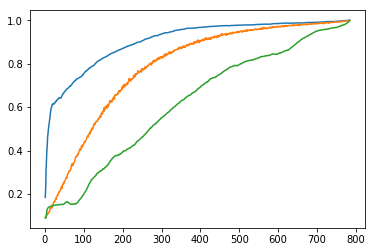

In [365]:
x = range(1,785)

plt.plot(x, accs)
plt.plot(x, accs_r)
#plt.plot(x, accs_m)
plt.plot(x, accs_n)
plt.plot()

In [362]:
dev_accs_n = np.load('data/rec_accs.npy')
dev_accs = np.load('data/rec_accs_pos.npy')
dev_accs_m = np.load('data/rec_accs_mid.npy')

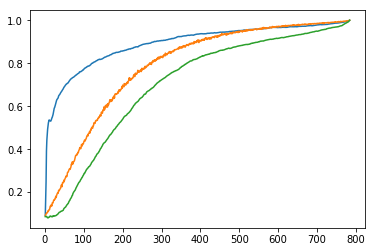

In [366]:
plt.plot(x, dev_accs)
plt.plot(x, accs_r)
#plt.plot(x, dev_accs_m)
plt.plot(x, dev_accs_n)
plt.show()

In [62]:
scores.shape

(10000, 784)

In [67]:
score_means = np.mean(scores, axis=0)

In [71]:
new_scores = np.subtract(scores,score_means)

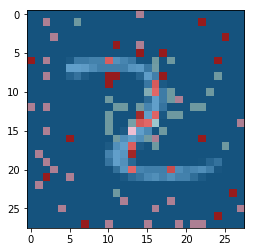

True label: 2
Predicted label: 2


In [80]:
explain_instance(2500,28, new_scores)

In [81]:
np.save('data/new_scores.npy', new_scores)

In [172]:
layer_dict = dict([(layer.name, layer) for layer in trained_model.layers])

In [173]:
layer_dict

{'dense_1': <keras.layers.core.Dense at 0xb440b5978>,
 'dense_2': <keras.layers.core.Dense at 0xb440a9fd0>,
 'dense_3': <keras.layers.core.Dense at 0xb440a92b0>,
 'dense_4': <keras.layers.core.Dense at 0xb441196d8>}

In [104]:
from keras import backend as K

This is the version that gives us the gradients of the loss wrt the input. We also want to get the gradients of params wrt a forward pass (see below),

In [259]:
layer_name = 'dense_4'
target_ind = 6

layer_output = layer_dict[layer_name].output
#loss = K.mean(layer_output[:,target_ind])
loss = K.categorical_crossentropy(layer_output, layer_output)

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, trained_model.input)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([trained_model.input], [loss, grads])

In [265]:
input_img_data = x_val[1:2,:] #np.random.random((1,784))

In [266]:
# run gradient ascent for 20 steps
for i in range(10000):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 0.003

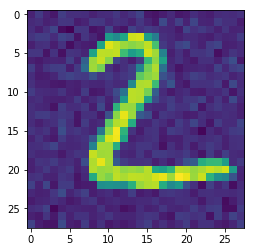

In [267]:
imshow(input_img_data.reshape(28,28))

Getting the gradients wrt each parameter

In [270]:
weights = trained_model.trainable_weights # weight tensors
gradients = trained_model.optimizer.get_gradients(trained_model.total_loss, weights) # gradient tensors
input_tensors = [trained_model.inputs[0], # input data
                 trained_model.sample_weights[0], # how much to weight each sample by
                 trained_model.targets[0], # labels
                 K.learning_phase(), # train or test mode
]

get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [277]:
inputs = [[x_val[17,:]], # X
          [1], # sample weights
          [y_val[17]], # y
          0 # learning phase in TEST mode
]

In [279]:
grds = get_gradients(inputs)

In [297]:
activations = K.function([trained_model.layers[0].input], [trained_model.layers[1].output])

In [327]:
acts = activations([x_val[17:18,:]])[0]

In [328]:
trained_model.layers

In [329]:
grds[4].shape

(50, 25)

In [343]:
deltas = np.divide(grds[4], np.swapaxes(acts,0,1))

/Users/matt_rounds/miniconda2/envs/XA3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [345]:
delts = np.zeros((deltas.shape[1]))

for i in range(deltas.shape[0]):
    if deltas[i,0] is not nan:
        delts = deltas[i,:]
        break

Ok, grads extracted from a run

In [391]:
grad_accs = np.load('data/grad_accs.npy')
neg_grad_accs = np.load('data/grad_accs_n.npy')

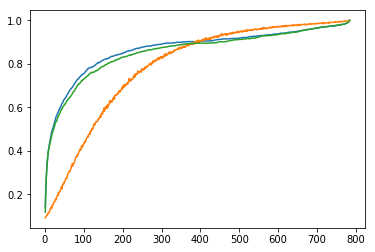

In [384]:
plt.plot(x, grad_accs)
plt.plot(x, accs_r)
plt.plot(x, neg_grad_accs)

plt.show()

In [35]:
A = np.array([4.1, 4.5, 3.2])

In [29]:
A.shape

(3,)

In [38]:
B = np.expand_dims(A,0)

In [39]:
B.shape

(1, 3)

In [26]:
A.ndim

1